<a href="https://colab.research.google.com/github/VigneshwaraChinnadurai/Competitions/blob/master/Identify%20the%20snake%20breed/snake_classifier_with_efficientnet_b7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm

     |████████████████████████████████| 245kB 9.3MB/s 


In [2]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 8.5MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
import numpy as np
import os
import pandas as pd
from fastai.vision.all import *

In [4]:
#STEP-1: Install Import Libraries
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#STEP-2: Autheticate E-Mail ID

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#STEP-3: Get File from Drive using file-ID

#2.1 Get the file
downloaded = drive.CreateFile({'id':'1ES0Mdtd6rk2Z7eB6bjeSY0iIWi9X9Mrc'})
# replace the id with id of file you want to access
downloaded.GetContentFile('snake_classification_dataset.zip') 

#STEP-4: Read File

#3.1 Read file as panda dataframe
!unzip snake_classification_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/b70a166bfe.jpg  
  inflating: dataset/train/d31875b68e.jpg  
  inflating: dataset/train/22c66793fb.jpg  
  inflating: dataset/train/a468b1390f.jpg  
  inflating: dataset/train/9e43d2cedc.jpg  
  inflating: dataset/train/2e0299e991.jpg  
  inflating: dataset/train/e0b85d8ff1.jpg  
  inflating: dataset/train/6a651ec04a.jpg  
  inflating: dataset/train/46c87716a5.jpg  
  inflating: dataset/train/8c40d4f073.jpg  
  inflating: dataset/train/96e4fb744c.jpg  
  inflating: dataset/train/794a698960.jpg  
  inflating: dataset/train/dad1934f35.jpg  
  inflating: dataset/train/a1c66a2b3c.jpg  
  inflating: dataset/train/b62484a8e4.jpg  
  inflating: dataset/train/09462814f1.jpg  
  inflating: dataset/train/97dbdb4dd0.jpg  
  inflating: dataset/train/3bd7f56164.jpg  
  inflating: dataset/train/a2576a2fa1.jpg  
  inflating: dataset/train/f462f66aa6.jpg  
  inflating: dataset/train/740e1a7fca.jpg  
  inflating: dataset/trai

In [5]:
dataset_path = Path('dataset/')
os.listdir(dataset_path)

['test', 'train.csv', 'train', 'test.csv']

In [6]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [7]:
train_df['path'] = train_df['image_id'].map(lambda x:dataset_path/'train'/(x+'.jpg'))
train_df = train_df.drop(columns=['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head(5)

,breed,path
0,pantherophis-obsoletus,dataset/train/72f93f0328.jpg
1,rhinocheilus-lecontei,dataset/train/ac97130026.jpg
2,coluber-constrictor,dataset/train/7bf7580fd4.jpg
3,agkistrodon-contortrix,dataset/train/567542d6ba.jpg
4,lampropeltis-triangulum,dataset/train/1b54d1dd2a.jpg


In [8]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 5508 images


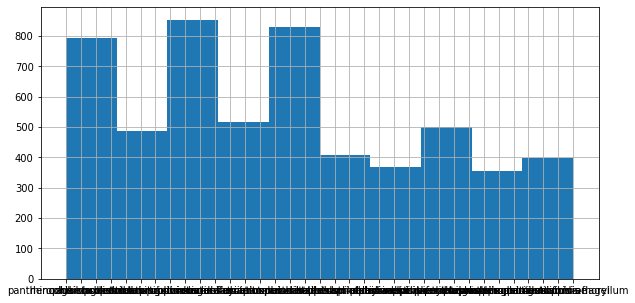

In [9]:
train_df['breed'].hist(figsize = (10, 5))

In [10]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 

128 171


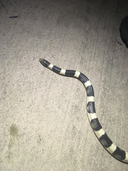

In [11]:
im

In [12]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=32

In [13]:
dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               label_col=0, #label is in the first column of the DataFrame
                               fn_col=1, #filename/path is in the second column of the DataFrame
                               bs=bs, #pass in batch size
                               item_tfms=item_tfms, #pass in item_tfms
                               batch_tfms=batch_tfms) #pass in batch_tfms

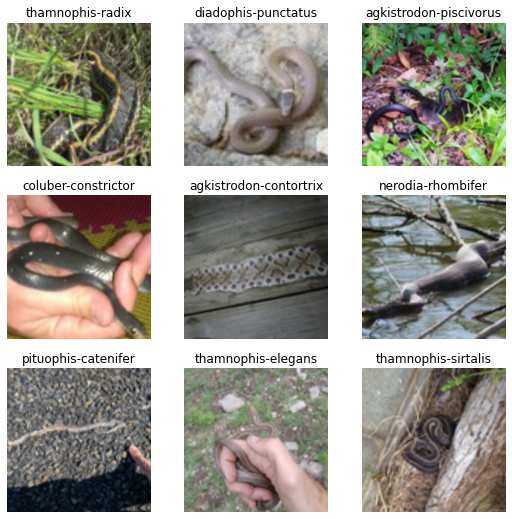

In [14]:
dls.show_batch()

In [15]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [16]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [17]:
learn = timm_learner(dls,
                     'tf_efficientnet_b7_ns', 
                     opt_func = ranger,
                     loss_func=LabelSmoothingCrossEntropy(),
                     metrics = [accuracy]).to_native_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b7_ns-1dbc32de.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b7_ns-1dbc32de.pth


In [18]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7412 sha256=6d1637464538cb1b7634934ddbfa8df930291557a094744cfc8f5dc1c7eef9b3
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 9.9 GB  | Proc size: 4.5 GB
GPU RAM Free: 13918MB | Used: 1161MB | Util   8% | Total 15079MB


In [23]:
"""
import torch, gc
gc.collect()
torch.cuda.empty_cache()
"""

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=7.585775847473997e-07)

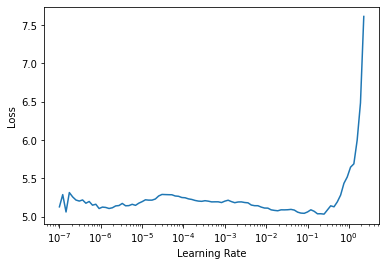

In [20]:
learn.lr_find()

In [21]:
learn.freeze()
learn.fit_flat_cos(1,1e-1, wd=0.5, cbs=[MixUp()])

epoch,train_loss,valid_loss,accuracy,time
0,3.651261,3.132082,0.190736,01:39


In [22]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [23]:
learn = learn.load('stage-1')

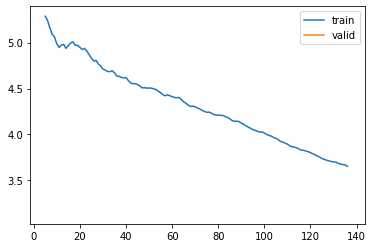

In [24]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=1.737800812406931e-06, lr_steep=1.5848931980144698e-06)

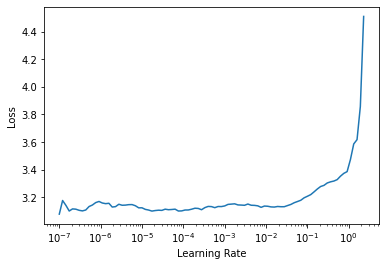

In [25]:
learn.unfreeze()
learn.lr_find()

In [26]:
learn.unfreeze()
learn.fit_flat_cos(10,2e-2,pct_start=0,cbs=[MixUp()])

epoch,train_loss,valid_loss,accuracy,time
0,3.041388,2.832831,0.288828,02:14
1,2.935900,2.800627,0.287920,02:14
2,2.789974,2.668579,0.326975,02:14
3,2.671890,2.572266,0.368756,02:14
4,2.508915,2.641027,0.335150,02:14
5,2.275880,2.540273,0.386013,02:14
6,2.051151,2.396523,0.421435,02:14
7,1.825954,2.420464,0.417802,02:14
8,1.656958,2.391665,0.427793,02:14
9,1.556532,2.398300,0.433242,02:14


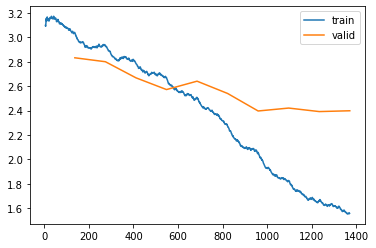

In [27]:
learn.recorder.plot_loss()

In [28]:
learn = learn.to_native_fp32()

In [29]:
learn.save('stage-2')

Path('models/stage-2.pth')

In [30]:
learn.export()

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

In [32]:
sample_df = pd.read_csv(dataset_path/'test.csv')
sample_df.head()

,image_id
0,7ede553357
1,3500b219e4
2,d43a78d6d9
3,1f36f26994
4,8cb85fc58e


In [33]:
_sample_df = sample_df.copy()
_sample_df['path'] = _sample_df['image_id'].map(lambda x:dataset_path/'test'/(x+'.jpg'))
print(_sample_df.head(5))
test_dl = dls.test_dl(_sample_df)

print(test_dl)

     image_id                         path
0  7ede553357  dataset/test/7ede553357.jpg
1  3500b219e4  dataset/test/3500b219e4.jpg
2  d43a78d6d9  dataset/test/d43a78d6d9.jpg
3  1f36f26994  dataset/test/1f36f26994.jpg
4  8cb85fc58e  dataset/test/8cb85fc58e.jpg


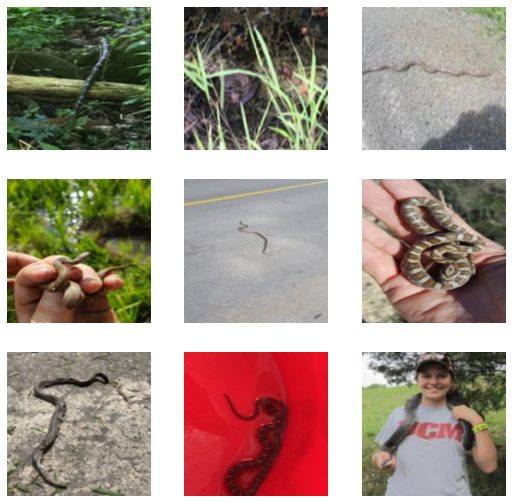

In [34]:
test_dl.show_batch()

In [35]:
preds, _ = learn.tta(dl=test_dl, n=8, beta=0)

In [37]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [39]:
sample_df.head()

,image_id,label
0,7ede553357,23
1,3500b219e4,1
2,d43a78d6d9,0
3,1f36f26994,28
4,8cb85fc58e,2


In [ ]:
one={0: 'agkistrodon-contortrix', 1: 'agkistrodon-piscivorus', 2: 'coluber-constrictor', 3: 'crotalus-atrox', 4: 'crotalus-horridus', 5: 'crotalus-ruber', 6: 'crotalus-scutulatus', 7: 'crotalus-viridis', 8: 'diadophis-punctatus', 9: 'haldea-striatula', 10: 'heterodon-platirhinos', 11: 'lampropeltis-californiae', 12: 'lampropeltis-triangulum', 13: 'masticophis-flagellum', 14: 'natrix-natrix', 15: 'nerodia-erythrogaster', 16: 'nerodia-fasciata', 17: 'nerodia-rhombifer', 18: 'nerodia-sipedon', 19: 'opheodrys-aestivus', 20: 'pantherophis-alleghaniensis', 21: 'pantherophis-emoryi', 22: 'pantherophis-guttatus', 23: 'pantherophis-obsoletus', 24: 'pantherophis-spiloides', 25: 'pantherophis-vulpinus', 26: 'pituophis-catenifer', 27: 'rhinocheilus-lecontei', 28: 'storeria-dekayi', 29: 'storeria-occipitomaculata', 30: 'thamnophis-elegans', 31: 'thamnophis-marcianus', 32: 'thamnophis-proximus', 33: 'thamnophis-radix', 34: 'thamnophis-sirtalis'}
print(one)

In [ ]:
sample_df['breed'] = sample_df['label'].map(lambda x:one[x])

In [ ]:
sample_df.head()
sample_df = sample_df.drop(columns=['label'])
sample_df.head()

In [38]:
sample_df.to_csv('Identify_snake_breed.csv',index=False)

In [40]:
from google.colab import files
files.download('Identify_snake_breed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>